### Generate plots for: 
- Prob of choosing card with prev rule, current rule, as a function of trials since rule switch
- Split by subject
- Plot along with model performance

In [16]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns
plt.rcParams.update({'font.size': 16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def load_agent_data(session, sub):
    if sub == "SA":
        beh_path = f"/data/patrick_res/rl/beh/fitted_belief_state_agent_session_{session}.csv"
    else: 
        beh_path = f"/data/patrick_res/rl/beh/fitted_belief_state_agent_BL_session_{session}.csv"
    beh = pd.read_csv(beh_path)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh["session"] = session
    return beh

def load_belief_state_beh_for_sub(sub):
    res = []
    for i in range(10):
        res.append(load_agent_data(i, sub))
    return pd.concat(res)

def compute_probs(beh):
    cur_res = beh.groupby(["session"], group_keys=True).apply(lambda group: behavioral_utils.get_prob_correct_by_block_pos(group, 40)).reset_index()
    cur_res["type"] = "Current Rule"
    cur_res["Prob Chose"] = cur_res["ProbCorrect"]

    prev_res = beh.groupby(["session"], group_keys=True).apply(lambda group: behavioral_utils.get_prob_perseveration_by_block_pos(group, 40)).reset_index()
    prev_res["type"] = "Previous Rule"
    prev_res["Prob Chose"] = prev_res["Prob Perseverate"]
    all_data = pd.concat([cur_res, prev_res])
    return all_data

def plot_for_sub(sub, ax):
    beh = behavioral_utils.load_all_beh_for_sub(sub)
    model_beh = load_belief_state_beh_for_sub(sub)

    sub_probs = compute_probs(beh)
    model_probs = compute_probs(model_beh)
    sns.lineplot(data=sub_probs, x="TrialInBlock", y="Prob Chose", hue="type", ax=ax, linewidth=3, errorbar="sd", palette=sns.mpl_palette('Dark2'))
    sns.lineplot(data=model_probs, x="TrialInBlock", y="Prob Chose", hue="type", linestyle="dotted", ax=ax, linewidth=3, errorbar="sd", palette=sns.mpl_palette('Dark2'))


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[:2], labels=labels[:2])
    for line in ax.get_legend().get_lines():
        line.set_linewidth(4)

    ax.set_xlabel("Trials after rule switch")
    ax.set_ylabel("Prob. of Choosing Card with Rule") 
    ax.set_xticks(np.arange(0, 40, 5).astype(int))
    ax.set_xticklabels(np.arange(0, 40, 5).astype(int))
    ax.axhline(0.25, color='black', linestyle='dotted', label="Chance")
    ax.set_title(f"Monkey {'S' if sub == 'SA' else 'B'}")


### Load and compute for monkey

/tmp/ipykernel_360813/2009243955.py:35: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.lineplot(data=sub_probs, x="TrialInBlock", y="Prob Chose", hue="type", ax=ax, linewidth=3, errorbar="sd", palette=sns.mpl_palette('Dark2'))
/tmp/ipykernel_360813/2009243955.py:36: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.lineplot(data=model_probs, x="TrialInBlock", y="Prob Chose", hue="type", linestyle="dotted", ax=ax, linewidth=3, errorbar="sd", palette=sns.mpl_palette('Dark2'))
/tmp/ipykernel_360813/2009243955.py:35: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.lineplot(data=sub_probs, x="TrialInBlock", y="Prob Chose", hue="type", ax=ax, linewidth=3, errorbar="sd", palette=sns.mpl_palette('Dark2'))
/tmp/ipykernel_360813/2009243955.py:36: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sn

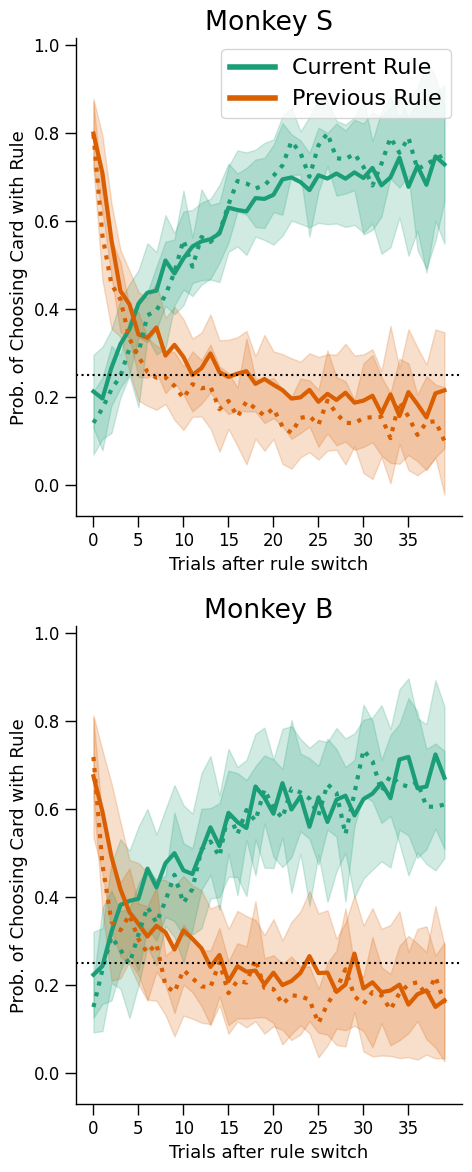

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(5, 12), sharey=True)
plot_for_sub("SA", ax=axs[0])
plot_for_sub("BL", ax=axs[1])

visualization_utils.format_plot(axs)
axs[1].get_legend().remove()
fig.tight_layout()
fig.savefig("/data/patrick_res/figures/wcst_paper/behavior/subjects_perf.png")
fig.savefig("/data/patrick_res/figures/wcst_paper/behavior/subject_perf.svg")